In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import cvxpy as cp
import scipy as sp
from numpy.linalg import matrix_power
import ipdb

ModuleNotFoundError: ignored

In [ ]:
#ADMM for solving min_x ||x||_1 + \epsilon*||y-Ax||^2   st. x>=0  (may not have this constrain)
#this function can be used to solve (7) for 1D/2D sparse signal
def myADMM(A,y,constrain=False,maxit=3000,tol=1e-16,epsilon=1e2,rho=50):
  #rho = 50   #the choice of rho must be careful!
  N = len(y)
  err = []
  x = np.random.randn(N,1)
  z = np.random.randn(N,1)
  u = np.random.randn(N,1)
  if constrain == True:
    for i in range(maxit):
      x = np.linalg.solve(2*epsilon*np.dot(A.T,A)+rho*sp.sparse.eye(N),2*epsilon*np.dot(A.T,y)+rho*(z-u))
      z = ((x+u)>(1./rho))*(x+u-1./rho)
      u = u + x - z
      err.append(np.linalg.norm(x-z))
      if i>50 and np.linalg.norm(x-z) < tol:
        print('iter',i)
        break
      if np.mod(i,100) == 0:
        print(i)
  else: 
    for i in range(maxit):
      x = np.linalg.solve(2*epsilon*np.dot(A.T,A)+rho*np.eye(N),2*epsilon*np.dot(A.T,y)+rho*(z-u))
      z = (abs(x+u)>(1./rho))*(abs(x+u)-1./rho)*np.sign(x+u)
      u = u + x - z
      err.append(np.linalg.norm(x-z))
      if i>100 and np.linalg.norm(x-z) < tol:
        print('iter',i)
        break
  return z,err
def l1solv(Fw1,meas):
# Create variable.
   x_l1 = cp.Variable(shape=(N,1))
   constraints = [x_l1>=0] #, cp.norm(Fw1.numpy()@x_l1-meas, 2)<=torch.norm(noise)]
# Form objective.
   obj = cp.Minimize(cp.norm(x_l1, 1)+ cp.norm((Fw1@x_l1)-meas, 2)*1e2)
# Form and solve problem.
   prob = cp.Problem(obj, constraints)
   prob.solve()
   x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
   plt.plot(x_l1.value,'y')
   #plt.plot(u,'c')
   #plt.plot(meas,'r')
   mx_norm = torch.norm(torch.from_numpy(D@x_l1.value[:,0]), 0.5)**0.5+(torch.norm(torch.from_numpy(D@x_l1.value[:,0]), 2))**2*1e-4
   psnr_recon = psnr2(u,x_l1.value.T)
   print('psnr:{:f}, mixednorm:{:f}'.format(psnr_recon,mx_norm))
   return mx_norm, psnr_recon
def psnr1(A,B):
  MSE = torch.mean((A-B)**2)**0.5
  return 20*np.log(torch.max(torch.abs(A))/MSE)/np.log(10)
def psnr2(A,B):
  MSE = np.mean((A-B)**2)**0.5
  return 20*np.log(np.amax(abs(A))/MSE)/np.log(10)

In [ ]:
#check correctness of the function above, compare with cvx 
def mytest(constraint=False,maxit1=1000,A=[],y=[],epsilon1=1e2,rho1=50):
  if A == []:
    N = 200
    A = np.random.randn(N,N)
    y = np.random.randn(N,1)
  N = len(y)
  x_l1 = cp.Variable(shape=(N,1))
  constraints = [x_l1>=0]
  obj = cp.Minimize(cp.norm(x_l1, 1) + epsilon1*cp.norm(y-A@x_l1, 2)**2) 
  if constraint == False:
    prob = cp.Problem(obj)
    x,err = myADMM(A,y,constrain=False,epsilon=epsilon1,rho=rho1,maxit=maxit1)
  else:
    prob = cp.Problem(obj, constraints)
    x,err = myADMM(A,y,constrain=True,epsilon=epsilon1,rho=rho1,maxit=maxit1)
  prob.solve()
  x_cvx = x_l1.value
  plt.figure(figsize=(10,5))
  plt.subplot(121),plt.plot(err)
  plt.subplot(122),plt.plot(x,'r'),plt.plot(x_cvx,'b')
  psnr_rec = psnr2(x,x_cvx)
  return x,x_cvx,psnr_rec

In [ ]:
#1D sparse signal and its mearsurements
N = 500
Ncount = 1000
alpha = 5
s = 1 / (2 * alpha)
A = (1-2*s)*np.diag(np.ones((N,1))[:,0],0) +s*np.diag(np.ones((N-1,1))[:,0],-1)+s*np.diag(np.ones((N-1,1))[:,0],1)
D = np.diag(np.ones((N,1))[:,0],0)-np.diag(np.ones((N-1,1))[:,0],-1)

spikes = 3
u = np.zeros((N,1))
k = np.random.randint(0,N-50,spikes)
u[k+25] = 50*np.random.rand(spikes,1)
#u = np.cumsum(u)
u = abs(u).reshape(N,1)
u[:60] = 0                      
u[-60:] = 0

Fw = np.linalg.matrix_power(A, Ncount)
meas = (Fw@u).reshape(N,1)
noise = 1*np.random.randn(meas.shape[0],1)
measn = meas + noise  

In [ ]:
# linear filter
c = np.stack([np.linspace(0,30,30),np.linspace(30,0,30)],axis=1).T.reshape(60,1)
meas1 = np.copy(u)
for i in range(440):
    meas1[i+30] = u[i:(i+60)].T.dot(c)/sum(c)
meas1n = meas1 + 5*np.random.randn(meas1.shape[0],1)
# moving window filter
meas2 = np.copy(u)
for i in range(440):
    meas2[i+30] = np.mean(u[i:(i+60)])
meas2n = meas2 + 5*np.random.randn(meas2.shape[0],)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f8c0f963e10>,
 [<matplotlib.lines.Line2D at 0x7f8c0f952e10>])

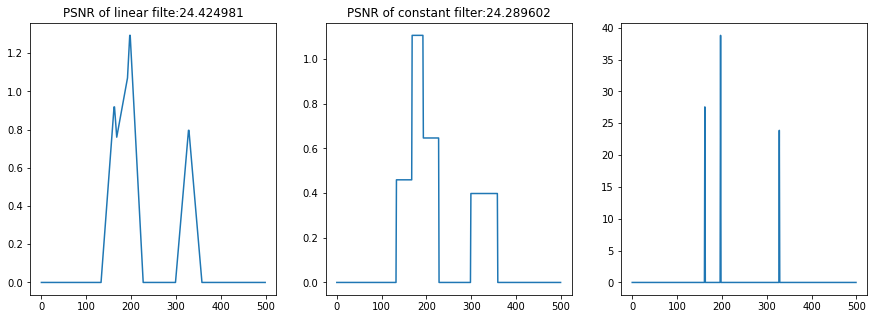

In [ ]:
#plot signal and measurenments
plt.figure(figsize=(15,5))
plt.subplot(131),plt.plot(meas1),plt.title('PSNR of linear filte:{:f}'.format(psnr2(u,meas1)))
plt.subplot(132),plt.plot(meas2),plt.title('PSNR of constant filter:{:f}'.format(psnr2(u,meas2)))
plt.subplot(133),plt.plot(u)

In [ ]:
t = np.linspace(100,2400,20)
a =[]
b =[]
for ti in range(20):
    u_rec,err = myADMM(np.linalg.matrix_power(A, int(t[ti])),meas1,constrain=True,rho=1)
    mix_norm = np.linalg.norm((D@u_rec).reshape(N,), 0.5)**0.5 + 1e-4*(np.linalg.norm((D@u_rec).reshape(N,), 2))**2
    psnr_rec = psnr2(u,u_rec)
    a.append(mix_norm)
    b.append(psnr_rec)
    print('N:',t[ti],'psnr',psnr_rec,'mixed norm:',mix_norm)

N: 100.0 psnr 25.042813033876236 mixed norm: 75.99680983059409
N: 221.05263157894737 psnr 24.38840051857875 mixed norm: 53.68236485656714
N: 342.10526315789474 psnr 27.011672771085752 mixed norm: 50.54938887432647
N: 463.1578947368421 psnr 25.67068892706714 mixed norm: 49.87654693258947
N: 584.2105263157895 psnr 24.454992069878767 mixed norm: 43.98766663695337
N: 705.2631578947369 psnr 23.379337301661735 mixed norm: 39.3499147392522
N: 826.3157894736842 psnr 23.809216272879016 mixed norm: 34.48967940532729
N: 947.3684210526316 psnr 28.494056432420592 mixed norm: 30.121430621925086
N: 1068.421052631579 psnr 33.49899843970294 mixed norm: 31.724816698567654
N: 1189.4736842105262 psnr 33.48417270969613 mixed norm: 32.385547967015334
N: 1310.5263157894738 psnr 29.93442421511103 mixed norm: 30.569610159866066
N: 1431.578947368421 psnr 24.75241365169997 mixed norm: 29.225720837713602
N: 1552.6315789473683 psnr 23.007096144728106 mixed norm: 31.036567691894053
N: 1673.6842105263158 psnr 23.426

psnr:21.984665, mixednorm:29.223856


(tensor(29.2239, dtype=torch.float64), 21.984665079702154)

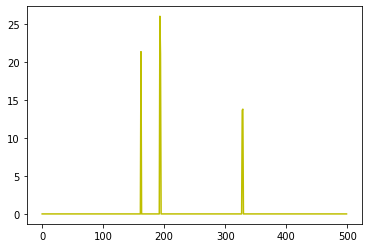

In [ ]:
l1solv(np.linalg.matrix_power(A,2000),meas1)

23.789899233835005


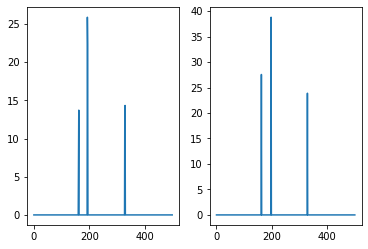

In [ ]:
N_recon = np.round(t[a==np.min(a)])
x,err = myADMM(np.linalg.matrix_power(A, int(N_recon)),meas1,constrain=True,rho=1)
plt.subplot(121),plt.plot(x)
plt.subplot(122),plt.plot(u)
print(psnr_rec)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


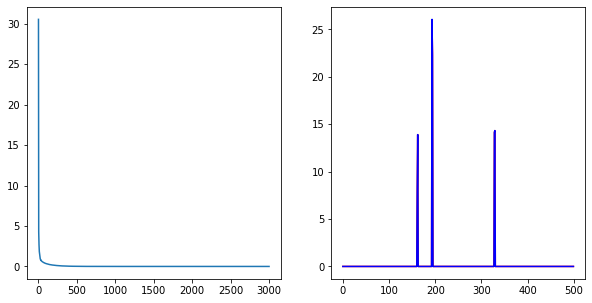

In [ ]:
x,x_cvx,psnr_rec = mytest(constraint=True,maxit1=3000,A=np.linalg.matrix_power(A, int(N_recon)),y=meas1,rho1=1)

63.7609637240985


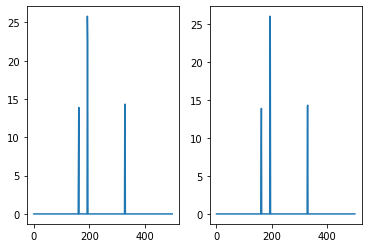

In [ ]:
plt.subplot(121),plt.plot(x)
plt.subplot(122),plt.plot(x_cvx)
print(psnr_rec)

In [ ]:
#1D sparse signal and its mearsurements
N = 10000
Ncount = 1000
alpha = 5
s = 1 / (2 * alpha)
A = (1-2*s)*np.diag(np.ones((N,1))[:,0],0) +s*np.diag(np.ones((N-1,1))[:,0],-1)+s*np.diag(np.ones((N-1,1))[:,0],1)
#A = sp.sparse.diags([1-2*s,s,s],[0,1,-1],shape=(N,N))
D = np.diag(np.ones((N,1))[:,0],0)-np.diag(np.ones((N-1,1))[:,0],-1)

spikes = 3
u = np.zeros((N,1))
k = np.random.randint(0,N-50,spikes)
u[k+25] = 50*np.random.rand(spikes,1)
#u = np.cumsum(u)
u = abs(u).reshape(N,1)
u[:60] = 0                      
u[-60:] = 0

Fw = np.linalg.matrix_power(A, Ncount)
meas = (Fw@u).reshape(N,1)
noise = 1*np.random.randn(meas.shape[0],1)
measn = meas + noise  

In [ ]:
# linear filter
c = np.stack([np.linspace(0,30,30),np.linspace(30,0,30)],axis=1).T.reshape(60,1)
meas1 = np.copy(u)
for i in range(440):
    meas1[i+30] = u[i:(i+60)].T.dot(c)/sum(c)
meas1n = meas1 + 5*np.random.randn(meas1.shape[0],1)
# moving window filter
meas2 = np.copy(u)
for i in range(440):
    meas2[i+30] = np.mean(u[i:(i+60)])
meas2n = meas2 + 5*np.random.randn(meas2.shape[0],)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in double_scalars


(<matplotlib.axes._subplots.AxesSubplot at 0x7f8c0e3a41d0>,
 [<matplotlib.lines.Line2D at 0x7f8c0e36dd10>])

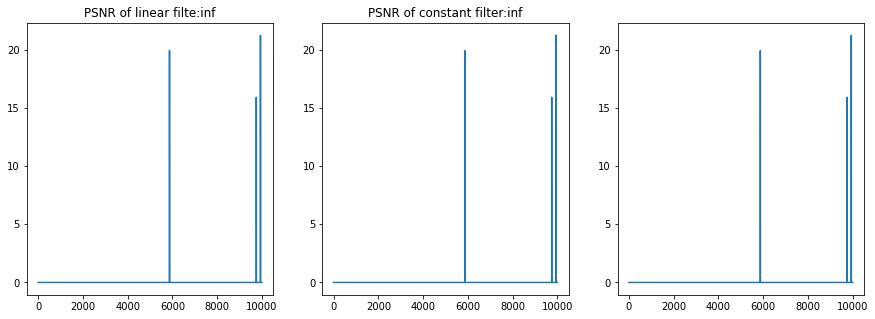

In [ ]:
#plot signal and measurenments
plt.figure(figsize=(15,5))
plt.subplot(131),plt.plot(meas1),plt.title('PSNR of linear filte:{:f}'.format(psnr2(u,meas1)))
plt.subplot(132),plt.plot(meas2),plt.title('PSNR of constant filter:{:f}'.format(psnr2(u,meas2)))
plt.subplot(133),plt.plot(u)

In [ ]:
x,x_cvx,psnr_rec = mytest(constraint=True,maxit1=3000,A=Fw,y=meas1,rho1=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


0
